# Project 2
### Logistic Regression of Galaxy Morphological Type Frequencies by Redshift

### 1. Importing Packages and Reading in the Data

In [18]:
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
import math

### 2. Visual Inspection of Data

In [19]:
df = pd.read_csv('GalaxyMorphZ.tsv', sep="\t")
df=df.sample(n=50000,random_state=5731)
df.head()

,objID,z,SVMPython,RFPython
119323,1237674650461798526,0.098945,1,1
301753,1237652599025173241,0.081600,1,1
265959,1237665129100411317,0.023152,1,1
266280,1237654948912431302,0.066669,0,0
289383,1237662306740207964,0.032803,1,1


In [20]:
df.describe()

,objID,z,SVMPython,RFPython
count,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,1.237662e+18,0.063506,0.557780,0.582920
std,6.043641e+12,0.023075,0.496655,0.493081
min,1.237646e+18,0.003015,0.000000,0.000000
25%,1.237658e+18,0.046093,0.000000,0.000000
50%,1.237662e+18,0.067179,1.000000,1.000000
75%,1.237666e+18,0.082197,1.000000,1.000000
max,1.237680e+18,0.100000,1.000000,1.000000


Text(0.5, 1.0, 'Proportions According to SVM')

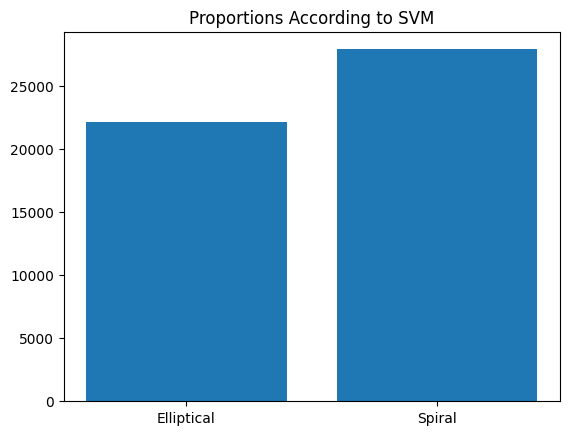

In [21]:
# We will just look at the SVM classifications in this project

N = len(df)

elliptical = df[df['SVMPython']==0]
spiral = df[df['SVMPython']==1]
num_elliptical = len(elliptical)
num_spiral = len(spiral)

plt.bar(['Elliptical','Spiral'],[num_elliptical,num_spiral])
plt.title("Proportions According to SVM")

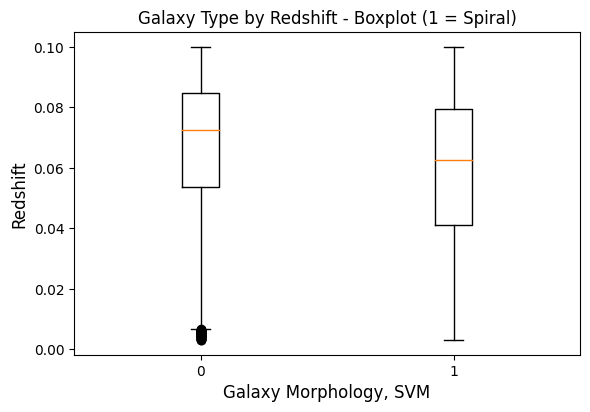

In [22]:
# Boxplot
spirals = df['SVMPython'] == 1

plt.figure(figsize = (6, 4))

plt.boxplot(x = [df['z'][~spirals], df['z'][spirals]], labels = '01');

plt.ylabel('Redshift', fontsize = 12);
plt.xlabel('Galaxy Morphology, SVM', fontsize = 12);


plt.tight_layout()
plt.title("Galaxy Type by Redshift - Boxplot (1 = Spiral)")

plt.show()

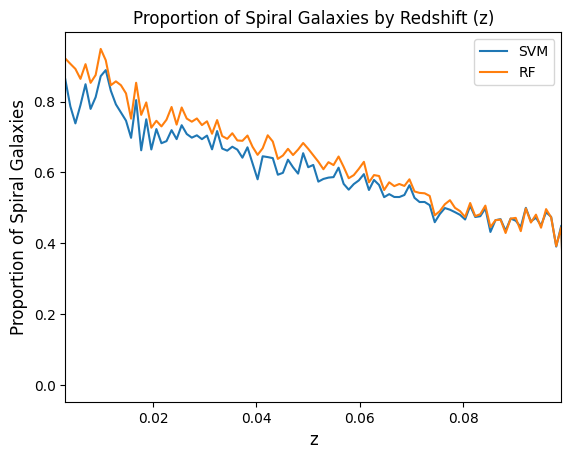

In [23]:
# Plotting proportions of spiral over redshift

x=np.linspace(np.min(df["z"]),np.max(df["z"]),100)
y1=np.zeros(100)
y2=np.zeros(100)
sep=x[1]-x[0]
for i,z in enumerate(x):
    try:
        y1[i]=len(df[(df["SVMPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y1[i]=0
for i,z in enumerate(x):
    try:
        y2[i]=len(df[(df["RFPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y2[i]=0
plt.plot(x,y1,label="SVM")
plt.plot(x,y2,label="RF")
plt.legend()
plt.xlim(x[0],x[-2])
plt.xlabel("z", fontsize=12)
plt.ylabel("Proportion of Spiral Galaxies", fontsize=12)
plt.title("Proportion of Spiral Galaxies by Redshift (z)")
plt.show()


### 3. Establishing Priors and Creating Model

In [24]:
#Minimum Effective Sample Size - we have 6: mean, lb and ub for CI for both b0 and b1

import pymc as pm
import arviz as az
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

N_sample = minESS(6).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8708


In [25]:
# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# Building the model
with pm.Model() as model:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/66441911.py:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/66441911.py:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0, tau=0.01, testval=0.0)


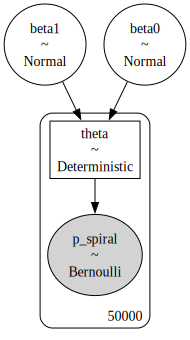

In [26]:
# Visualizing Model
from pymc import Model, Normal, Gamma,model_to_graphviz
model_to_graphviz(model)

In [27]:
# Took about 1 minute to run this cell
N_sample = 1000
with model:
    #Draw 8708 posterior samples
    idata = pm.sample(N_sample,step=pm.NUTS())
idata

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### 4. Prior Predictive Check

### 5. Posterior Distributions

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

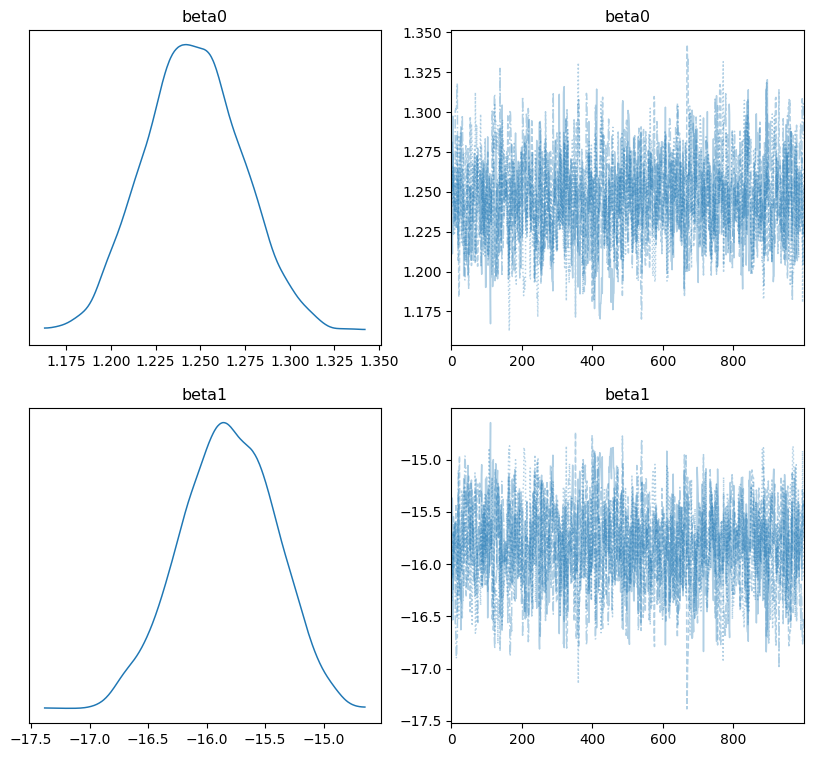

In [28]:
# Posterior Distributions
az.plot_trace(idata,var_names=['beta0','beta1'],figsize=(10, 9), combined=True) #Use 'combined=true' to show all chains together

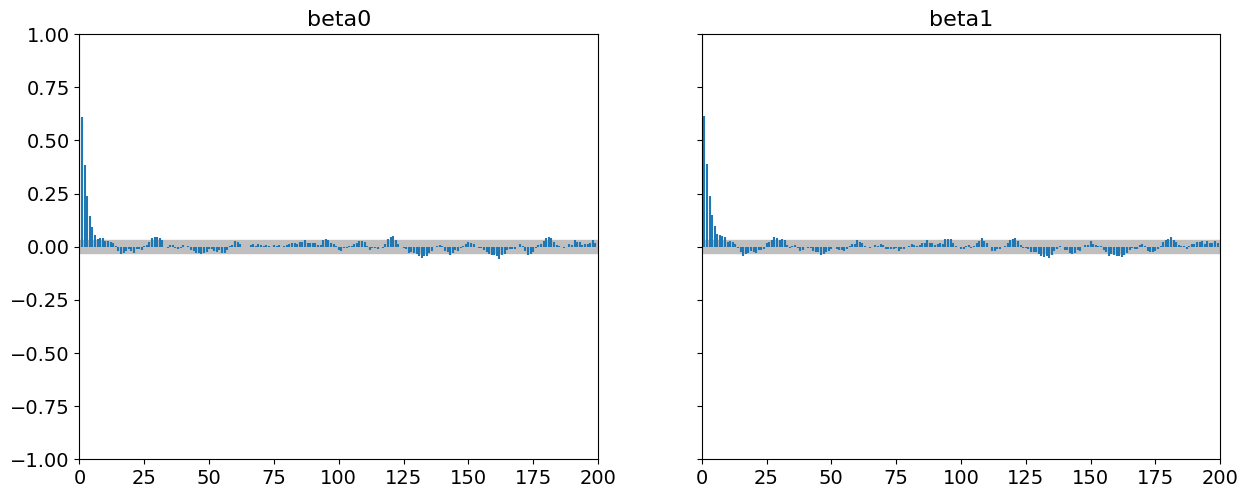

In [29]:
# Auto Correlation Plots
az.plot_autocorr(idata, var_names=['beta0','beta1'],combined=True, max_lag=200);


### 6. Sensitivity Analysis

In [30]:
# We will use the standard reference prior for our Betas (Normal with tau = 1, mu = 0)
y = df['SVMPython']
x = df['z']

# mu = 1, tau = 0.01
with pm.Model() as model1:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=1, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=1, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);
# Took about 10 minutes to run this cell
N_sample = 1000
with model1:
    #Draw 8708 posterior samples
    idata1 = pm.sample(N_sample,step=pm.NUTS())
print("Beta0,Beta1 mu=1:")
print(az.summary(idata1, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']])

######################################################################

# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# mu = 0.01, tau = 0.01
with pm.Model() as model2:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=0.01, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0.01, tau=0.01, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);
# Took about 10 minutes to run this cell
N_sample = 1000
with model2:
    #Draw 8708 posterior samples
    idata2 = pm.sample(N_sample,step=pm.NUTS())
print("Beta0,Beta1 mu=0.01:")
print(az.summary(idata2, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']])

######################################################################

# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# mu = 0.01, tau = 1
with pm.Model() as model3:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=0.01, tau=1, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0.01, tau=1, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);
# Took about 10 minutes to run this cell
N_sample = 1000
with model3:
    #Draw 8708 posterior samples
    idata3 = pm.sample(N_sample,step=pm.NUTS())
print("Beta0,Beta1 mu=0.01, sigma=1:")
print(az.summary(idata3, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']])

######################################################################

# We will use the standard reference prior for our Betas (Normal with tau = 0.01, mu = 0)
y = df['SVMPython']
x = df['z']

# mu = 1, tau = 1
with pm.Model() as model4:
    # Priors on Beta
    beta0 = pm.Normal('beta0', mu=1, tau=1, testval=0.0)
    beta1 = pm.Normal('beta1', mu=1, tau=1, testval=0.0)

    # Drawing theta using sigmoid
    theta = pm.Deterministic('theta', pm.math.sigmoid(beta0+beta1*x))

    # Bernoulli output using theta
    observed = pm.Bernoulli('p_spiral',theta,observed=y)

    #start=pm.find_MAP()
    #step = pm.NUTS()
    # Posterior sampling
    #trace = pm.sample(N_sample, step=step, return_inferencedata=True);
# Took about 10 minutes to run this cell
N_sample = 1000
with model4:
    #Draw 8708 posterior samples
    idata4 = pm.sample(N_sample,step=pm.NUTS())
print("Beta0,Beta1 mu=1, sigma=1:")
print(az.summary(idata4, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']])

# The posterior is very insensitive to the prior!

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=1, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=1, tau=0.01, testval=0.0)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Beta0,Beta1 mu=1:
          mean   hdi_3%  hdi_97%
beta0   1.2457   1.1937   1.2973
beta1 -15.8149 -16.5713 -15.1004


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:38: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0.01, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:39: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0.01, tau=0.01, testval=0.0)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Beta0,Beta1 mu=0.01:
          mean   hdi_3%  hdi_97%
beta0   1.2472   1.1995   1.3017
beta1 -15.8380 -16.5946 -15.0590


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:68: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=0.01, tau=1, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:69: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=0.01, tau=1, testval=0.0)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


Beta0,Beta1 mu=0.01, sigma=1:
          mean   hdi_3%  hdi_97%
beta0   1.1026   1.0556   1.1517
beta1 -13.6037 -14.3300 -12.9345


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:98: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta0 = pm.Normal('beta0', mu=1, tau=1, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_35284/3448680716.py:99: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta1 = pm.Normal('beta1', mu=1, tau=1, testval=0.0)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


Beta0,Beta1 mu=1, sigma=1:
          mean   hdi_3%  hdi_97%
beta0   1.0929   1.0452   1.1374
beta1 -13.4512 -14.1499 -12.7982


### 7. Posterior Predictive Check

In [31]:
# To Do

### 8. Final Results

In [32]:
# Summary
az.summary(idata, var_names=['beta0','beta1'],round_to=4)[['mean','hdi_3%','hdi_97%']]


,mean,hdi_3%,hdi_97%
beta0,1.2460,1.1954,1.2951
beta1,-15.8208,-16.5293,-15.0450


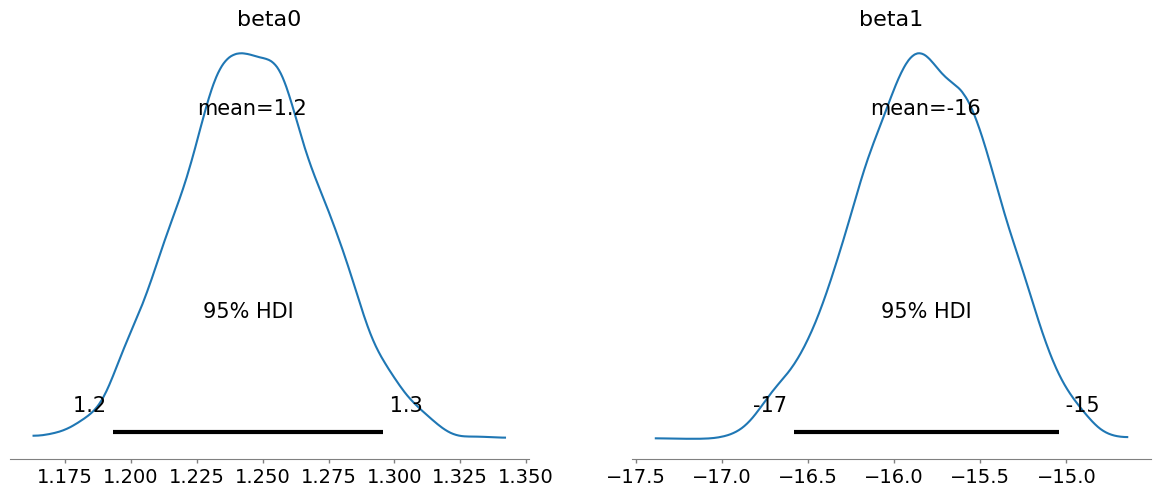

In [33]:
# Posterior Plots with Credible Interval
az.plot_posterior(idata, var_names=['beta0','beta1'], hdi_prob=.95);


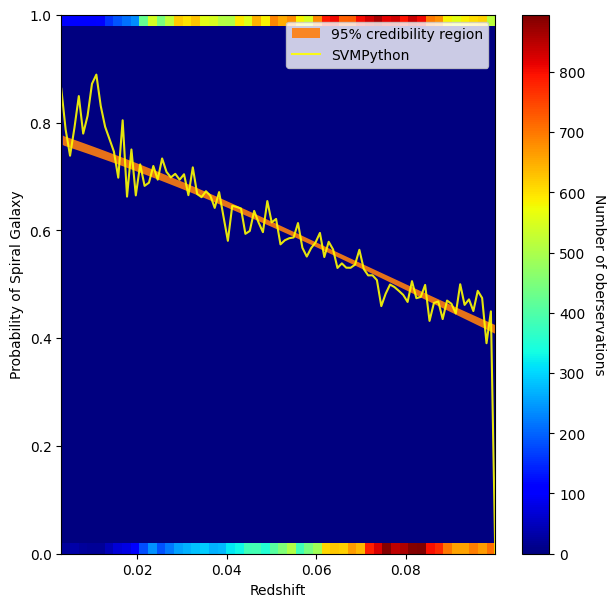

In [34]:
# To Do: Plot original data (maybe some randomly sampled points since we have so many?) and Logistic regression fit line
f, ax1 = plt.subplots(figsize=(7, 7))

y = df['SVMPython']
x = df['z']


res = ax1.hist2d(x, y, (50, 50), cmap=plt.cm.jet)
cbar = f.colorbar(res[3], ax = ax1)
cbar.set_label('Number of oberservations', rotation=270, labelpad=15)

# Code for Confidence Interval:
az.plot_hdi(x,
    idata.posterior.theta,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.90, "linewidth": 0, "label":"95% credibility region"},
    color="C1", plot_kwargs={},
    ax = ax1
)

x=np.linspace(np.min(df["z"]),np.max(df["z"]),100)
y1=np.zeros(100)
for i,z in enumerate(x):
    try:
        y1[i]=len(df[(df["SVMPython"]==1)&(df["z"]>z)&(df["z"]<z+sep)])/len(df[(df["z"]>z)&(df["z"]<z+sep)])
    except:
        y1[i]=0

#ax1.xlim(x[0],x[-2])
ax1.plot(x,y1,label="SVMPython", color='yellow', alpha = .9)

ax1.set_xlabel('Redshift')
ax1.set_ylabel('Probability of Spiral Galaxy')
ax1.legend()